## Setup

In [1]:
import os

from dataclasses import asdict
from pathlib import Path
from typing import List, Tuple

import torch
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib.colors import to_rgba
from scipy.stats import bootstrap
from transformers.hf_argparser import HfArgumentParser

from procyon.data.data_utils import DATA_DIR
from procyon.data.it_data_config import (
    expand_datasets_on_splits,
    ITMultiDatasetConfig,
)
from procyon.evaluate.framework.args import EvalArgs
from procyon.evaluate.framework.utils import (
    load_and_validate_model_args,
    override_data_and_model_args,
)
from procyon.training.training_args_IT import (
    DataArgs,
    ModelArgs,
    update_data_args_data_dir,
)

In [2]:
base_path = Path("/n/home08/rcalef/sandbox/projects/txplm/canonical_evals/")

our_model_name = "ProCyon"
zero_shot_name = "ProCyon (zero shot)"

# Load benchmarking results

In [3]:
retrieval_dirs = {
    base_path / "eval_new_splits": ["ProCyon"],
    base_path / "new_split_evals" / "zero_shot_baselines": ["BioTranslator", "ProtST"],
    base_path / "new_split_evals" / "simple_baselines": [
        "BlastKnn",
        "ESM3Knn",
        "ESM3MLP",
        "ESMKnn",
        "ESMMLP",
        "GearNetKnn",
        "GearNetMLP",
        "MajorityRule",
        "UniformRandom",
        "WeightedRandom",
    ],
}

retrieval_dir_by_model = {
    model: path for path, models in retrieval_dirs.items() for model in models
}

qa_dirs = {
    base_path / "eval_new_splits": ["ProCyon"],
    base_path / "new_split_evals" / "simple_baselines": [
        "BlastKnn",
        "ESM3Knn",
        "ESM3MLP",
        "ESMKnn",
        "ESMMLP",
        "GearNetKnn",
        "GearNetMLP",
    ],
    base_path / "eval_new_splits" / "protllm_eval_only": ["ProtLLM"],

}


qa_dir_by_model = {
    model: path for path, models in qa_dirs.items() for model in models
}

zero_shot_models = [
    "ProCyon",
    "BioTranslator",
    "ProtST",
]

In [4]:
# Use ProCyon evals to get datasets
config_yml = retrieval_dir_by_model["ProCyon"] / "args.yml"
parser = HfArgumentParser((EvalArgs, DataArgs, ModelArgs))
eval_args, data_args, model_args = parser.parse_yaml_file(config_yml)

separate_splits = True
keep_splits_union = False

# Check if we want to override ModelArgs using a ProCyon checkpoint
if eval_args.model_args_from_checkpoint != "":
    checkpoint_dir = eval_args.model_args_from_checkpoint
    print(f"Loading ModelArgs from ProCyon checkpoint: {checkpoint_dir}")
    model_args = torch.load(os.path.join(checkpoint_dir, "model_args.pt"))
    model_args = ModelArgs(**asdict(model_args))

if eval_args.data_args_from_checkpoint != "":
    checkpoint_dir = eval_args.data_args_from_checkpoint
    print(f"Loading DataArgs from ProCyon checkpoint: {checkpoint_dir}")
    loaded_data_args = torch.load(os.path.join(checkpoint_dir, "data_args.pt"))
    loaded_data_args = DataArgs(**asdict(loaded_data_args))

    update_data_args_data_dir(loaded_data_args)

    # Prefer to use the data config specified in data_args passed into this function
    # over one specified in the serialized data config.
    if data_args.it_data_config_yml is not None:
        loaded_data_args.it_data_config_yml = data_args.it_data_config_yml
    data_args = loaded_data_args

# Check if we want to override any of the DataArgs or ModelArgs values parsed
# from the model checkpoint.
if eval_args.override_model_data_args_yml is not None:
    override_data_and_model_args(
        data_args, model_args, eval_args.override_model_data_args_yml
    )

# Parse model specifications.
models = load_and_validate_model_args(eval_args.models_config_yml)

config = ITMultiDatasetConfig.load_from_yaml(data_args.it_data_config_yml)
if separate_splits:
    config.testing_datasets = expand_datasets_on_splits(
        config.testing_datasets, keep_splits_union
    )

Loading ModelArgs from ProCyon checkpoint: /n/holylfs06/LABS/mzitnik_lab/Lab/PLM/huggingface_repos/ProCyon-Split
Loading DataArgs from ProCyon checkpoint: /n/holylfs06/LABS/mzitnik_lab/Lab/PLM/huggingface_repos/ProCyon-Split
updating data args DATA_DIR from /n/holystore01/LABS/mzitnik_lab/Lab/PLM/ -> /n/holylfs06/LABS/mzitnik_lab/Lab/PLM/huggingface_repos/ProCyon-Instruct


In [5]:
func_task = "Protein function"
comp_task = "Cellular component"
path_task = "Biological pathway"
targ_task = "Drug target"
dpi_task = "Drug-protein interaction"
dis_task = "Disease association"
ec_task = "EC number"
dom_task = "Protein domains"

task_order = [
    func_task,
    comp_task,
    path_task,
    ec_task,
    targ_task,
    dpi_task,
    dis_task,
    #dom_task,
]

task_map = {
    'protein_go:process': func_task,
    'protein_go:function': func_task,
    'protein_reactome:all': path_task,
    'protein_go:component': comp_task,
    'protein_drugbank:drug_target': targ_task,
    'protein_drugbank:drug_enzyme': dpi_task,
    'protein_drugbank:drug_carrier': dpi_task,
    'protein_drugbank:drug_transporter':  dpi_task,
    'protein_disgenet:all': dis_task,
    'protein_omim:all': dis_task,
    'protein_ec:all': ec_task,
    'domain_pfam:all': dom_task,
    'domain_go:process': dom_task,
    'domain_go:function': dom_task,
    'domain_go:component': dom_task
}

In [6]:
_split_maps = {
    "pt_ft": ["pt_ft"],
    "few_shot": ["few_shot", "zero_shot_easy", "zero_shot"],
    "zero_shot": ["zero_shot_hard"],
}
split_maps = {
    x : k for k, v in _split_maps.items() for x in v
}

def map_split(x):
    return split_maps.get(x, "few_shot")

_split_maps_old = {
    "pt_ft": ["pt_ft"],
    "few_shot": ["few_shot"],
    "zero_shot": ["zero_shot", "zero_shot_hard"],
}
split_maps_old = {
    x : k for k, v in _split_maps_old.items() for x in v
}

def map_split_old(x):
    return split_maps_old.get(x, "few_shot")

def parse_dataset_string(s: str) -> Tuple[str, str, str]:
    aaseq, text, oth = s.split("_", maxsplit=2)
    if "eval" in oth:
        relation, split = [x.strip("_").rstrip("_") for x in oth.split("eval")]
        if split not in ["pt_ft", "zero_shot", "zero_shot_easy", "zero_shot_hard"]:
            split = "few_shot"
    else:
        relation = oth
        split = "all"
    return aaseq + "_" + text, relation, split


def get_per_text_retrieval_results(model: str, key: str) -> pd.DataFrame:
    path = retrieval_dir_by_model[model] / "retrieval" / model/ key / "per_text_metrics.tsv"
    return pd.read_table(path)

def get_qa_results(model: str, key: str) -> pd.DataFrame:
    path = qa_dir_by_model[model] / "qa" / model/ key / "results_dict.pkl"
    return pd.DataFrame(pd.read_pickle(path))

def load_and_map(
    model: str,
    orig_key: str,
    benchmark_task: str = "retrieval",
) -> pd.DataFrame:
    dataset, relation, split = parse_dataset_string(orig_key)
    mapped_split = map_split(split)

    dataset_relation = dataset + ":" + relation
    task = task_map[dataset_relation]

    if benchmark_task == "retrieval":
        results = (
            get_per_text_retrieval_results(model, orig_key)
            .drop(columns=["sample_num"])
            .groupby("query_id")
            .mean()
            .reset_index()
        )
    elif benchmark_task == "qa":
        results = (
            get_qa_results(model, orig_key)
            .assign(
                correct=lambda x: x.pred == x.y,
            )
            .drop(columns=["pred", "y"])
        )
    else:
        raise ValueError(f"unknown task: {benchmark_task}")

    return (
        results
        .assign(
            dataset_relation=dataset_relation,
            dataset=dataset,
            orig_split=split,
            orig_plot_split=map_split_old(split),
            plot_split=mapped_split,
            plot_task=task,
        )
    )

In [7]:
all_results = []
for dset in config.testing_datasets:
    for relation in dset.relations:
        dset_key = dset._construct_key(relation)
        for model in retrieval_dir_by_model.keys():
            if "zero_shot" in dset_key and model not in zero_shot_models:
                continue
            all_results.append(
                load_and_map(model, dset_key)
                .assign(model=model)
            )

all_results = pd.concat(all_results)
print(all_results.shape)
all_results.head()

(94846, 17)


,query_id,precision_k10,recall_k10,precision_k20,recall_k20,precision_k100,recall_k100,Fmax,auroc,auprc,dataset_relation,dataset,orig_split,orig_plot_split,plot_split,plot_task,model
0,0,0.30,0.750000,0.170000,0.85,0.090909,1.0,0.732857,0.881875,0.652682,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
1,1,0.20,1.000000,0.100000,1.00,0.090909,1.0,1.000000,1.000000,1.000000,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
2,5,0.20,1.000000,0.100000,1.00,0.090909,1.0,0.603175,0.887500,0.512143,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
3,8,0.22,0.733333,0.150000,1.00,0.090909,1.0,0.667619,0.881111,0.577133,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
4,9,0.10,1.000000,0.090909,1.00,0.090909,1.0,0.866667,0.970000,0.800000,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon


In [8]:
all_results.query("model == 'ProCyon' and dataset == 'protein_drugbank'").orig_split.value_counts()

orig_split
pt_ft             1198
zero_shot_hard     461
few_shot           343
zero_shot_easy     312
zero_shot           48
Name: count, dtype: int64

In [9]:
all_results.query("model == 'ESM3MLP' and dataset == 'protein_drugbank'").orig_split.value_counts()

orig_split
pt_ft       1008
few_shot     197
Name: count, dtype: int64

In [10]:
all_results.query("model == 'ProCyon'").dataset.value_counts()

dataset
protein_go          3322
protein_drugbank    2362
protein_reactome    2069
protein_omim        1373
protein_ec           875
protein_disgenet     205
Name: count, dtype: int64

In [11]:
all_results.query("model == 'ProCyon'").dataset_relation.value_counts()

dataset_relation
protein_go:process                   2421
protein_reactome:all                 2069
protein_omim:all                     1373
protein_drugbank:drug_target         1110
protein_ec:all                        875
protein_drugbank:drug_enzyme          677
protein_go:function                   557
protein_drugbank:drug_transporter     402
protein_go:component                  344
protein_disgenet:all                  205
protein_drugbank:drug_carrier         173
Name: count, dtype: int64

In [12]:
data_root = os.path.join(DATA_DIR, "integrated_data", "v1")

all_counts = []
text_counts = []
seen = set()
for dset in config.testing_datasets:
    dset_key = f"{dset.aaseq_type}_{dset.text_type}"
    if dset_key in seen:
        continue
    seen.add(dset_key)

    print(dset_key)
    relations_path = os.path.join(
        data_root,
        dset_key,
        dset.text_split_method,
        f"{dset_key}_relations_indexed.unified.csv",
    )
    relations = pd.read_csv(relations_path)
    all_counts.append(
        relations
        .loc[lambda x: x.split.str.contains("eval")]
        .split
        .value_counts()
        .to_frame()
        .reset_index()
        .assign(
            dataset=dset_key
        )
    )
    text_counts.append(
        relations
        .loc[lambda x: x.split.str.contains("eval")]
        .drop_duplicates("text_id")
        .split
        .value_counts()
        .to_frame()
        .reset_index()
        .assign(
            dataset=dset_key
        )
    )
all_counts = pd.concat(all_counts)
text_counts = pd.concat(text_counts)

all_counts.head()

protein_go


protein_reactome
protein_drugbank
protein_disgenet
protein_omim
protein_ec


,split,count,dataset
0,eval_five_shot,13564,protein_go
1,eval_pt_ft,12837,protein_go
2,eval_zero_shot_hard,6117,protein_go
3,eval_zero_shot,5956,protein_go
0,eval_two_shot,13162,protein_reactome


In [13]:
(
    text_counts
    .loc[lambda x: x.split.str.contains("eval")]
    .loc[lambda x: ~x.split.str.contains("zero")]
    .groupby("dataset")
    ["count"]
    .sum()
    .sort_values()
)

dataset
protein_disgenet      24
protein_omim          63
protein_ec           171
protein_drugbank    1036
protein_reactome    1811
protein_go          3048
Name: count, dtype: int64

In [14]:
(
    text_counts
    .loc[lambda x: x.split.str.contains("eval")]
    .loc[lambda x: ~x.split.str.contains("zero")]
    .groupby("dataset")
    ["count"]
    .sum()
    .sum()
)

6153

In [15]:
(
    all_results
    .loc[lambda x: ~x.orig_split.str.contains("zero")]
    .query("model == 'ProCyon'")
    .dataset
    .value_counts()
)

dataset
protein_go          3048
protein_reactome    1811
protein_drugbank    1541
protein_ec           171
protein_omim          63
protein_disgenet      24
Name: count, dtype: int64

In [16]:
(
    all_counts
    .loc[lambda x: x.split.str.contains("eval")]
    .loc[lambda x: ~x.split.str.contains("zero")]
    .groupby("dataset")
    ["count"]
    .sum()
)

dataset
protein_disgenet     1040
protein_drugbank     3301
protein_ec           1169
protein_go          26401
protein_omim          256
protein_reactome    25651
Name: count, dtype: int64

In [17]:
(
    all_counts
    .loc[lambda x: x.split.str.contains("eval")]
    .loc[lambda x: ~x.split.str.contains("zero")]
    .groupby("dataset")
    ["count"]
    .sum()
    .sum()
)

57818

In [18]:
all_qa_results = []
for dset in config.testing_datasets:
    for relation in dset.relations:
        dset_key = dset._construct_key(relation)
        for model in qa_dir_by_model.keys():
            if "zero_shot" in dset_key and model not in zero_shot_models:
                continue
            all_qa_results.append(
                load_and_map(model, dset_key, benchmark_task="qa")
                .assign(model=model)
            )

all_qa_results = (
    pd.concat(all_qa_results)
    .drop(columns=["seq_ids", "text_ids"])
)
print(all_qa_results.shape)
all_qa_results.head()

(1068078, 8)


,correct,dataset_relation,dataset,orig_split,orig_plot_split,plot_split,plot_task,model
0,True,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
1,False,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
2,False,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
3,False,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
4,True,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon


In [19]:
(
    all_qa_results
    .loc[lambda x: ~x.orig_split.str.contains("zero")]
    .model
    .value_counts()
)

model
ProCyon       115636
ProtLLM       115636
BlastKnn      114546
ESM3MLP       114546
ESM3Knn       114546
ESMKnn        114546
ESMMLP        114546
GearNetKnn    114546
GearNetMLP    114546
Name: count, dtype: int64

In [20]:
alpha = 1
procyon_color = "#9467BD"

model_colors = {
    "BLAST-kNN": to_rgba("dodgerblue", alpha),
    "ESM3-MLP": to_rgba("deepskyblue", alpha),
    "GearNet-MLP": to_rgba("darkblue", alpha),
    "BioTranslator": to_rgba("firebrick", alpha),
    "ProtST": to_rgba("salmon", alpha),
    "ProtLLM": to_rgba("red", alpha),
    our_model_name: procyon_color,
    zero_shot_name: procyon_color,
}

def calc_error_bounds(vals):
    rng = np.random.default_rng(seed=42)

    res = bootstrap(
        (vals,),
        statistic=np.mean,
        confidence_level=0.95,
        n_resamples=9999,
        batch=10000,
        random_state=rng,
        paired=False,
    )
    return (res.confidence_interval.low,res.confidence_interval.high)

In [21]:
split_rename = {
    "pt_ft": "Text frequently\nseen in training",
    "few_shot": "Text rarely\nseen in training",
    "zero_shot": "Text never\nseen in training",
}
split_order = list(split_rename.values())

# Check new splits

In [11]:
def split_comparison_plot(
    plot_data: pd.DataFrame,
    metric: str,
):
    fg = sns.FacetGrid(
        data=plot_data,
        row="plot_task",
        col="split_groups",
        margin_titles=False,
        col_order=["Old", "New"],
    )

    fg.map_dataframe(
        sns.barplot,
        x="plot_split",
        y=metric,
        order=split_order,
        edgecolor="black",
        errorbar=None,
    )
    # Set column titles only for the first row
    for col_idx, col_name in enumerate(fg.col_names):
        fg.axes[0, col_idx].set_title(f"{col_name} splits", fontsize=16, y=1.15, fontweight="normal")

    # Remove column titles for all other rows
    for i in range(1, len(fg.row_names)):
        for j in range(len(fg.col_names)):
            fg.axes[i, j].set_title("")

    # Add subtitles for each row
    for i, row_val in enumerate(fg.row_names):

        ax = fg.axes[i, 0]  # Get leftmost axis for this row
        ax.annotate(
            row_val,
            xy=(1.1, 1.05),  # Above the top of the row
            xycoords="axes fraction",
            ha="center",
            va="bottom",
            fontsize=14,
            fontweight="normal"
        )

    bottom_row_idx = len(fg.row_names) - 1  # Index of last row
    for ax in fg.axes[bottom_row_idx, :]:
        for label in ax.get_xticklabels():
            label.set_rotation(45)  # Rotate labels 45 degrees
            label.set_ha("right")

    fg.set_axis_labels(x_var="Phenotype group")

    for (task, split_type), ax in fg.axes_dict.items():
        counts = (
            plot_data
            .query("split_groups == @split_type and plot_task == @task")
            .plot_split.value_counts()
            [split_order]
        )
        ax.bar_label(ax.containers[0], labels=counts, padding=3, fontsize=12, label_type="center")

        rects = [x for x in ax.containers[0]]
        rects = sorted(rects, key=lambda x: x.get_x())

        x_coords = []
        y_coords = []
        yerr = []
        for rect, split in zip(rects, split_order):
            want_df = plot_data.query("split_groups == @split_type and plot_task == @task and plot_split == @split")
            err_lb, err_ub = calc_error_bounds(want_df[metric].values)

            xval = rect.get_center()[0]
            yval = rect.get_height()

            x_coords.append(xval)
            y_coords.append(yval)
            yerr.append(np.abs((err_lb - yval, err_ub - yval)))

            # Add text above the bar
            ax.text(
                x=xval,
                y=err_ub,
                s=f"{yval:.2f}",
                ha="center",
                va="bottom",
                fontsize=12,
            )

        yerr = np.array(yerr).T
        ax.errorbar(
            x=x_coords,
            y=y_coords,
            yerr=yerr,
            fmt="none",
            c="k",
            alpha=0.8,
            elinewidth=2,
        )

## Retrieval

In [12]:
procyon_data = all_results.query("model == 'ProCyon'")
plot_data = (
    pd.concat((
        procyon_data[["Fmax", "plot_task", "plot_split"]].assign(split_groups="new"),
        (procyon_data[["Fmax", "plot_task", "orig_plot_split"]]
        .rename(columns={"orig_plot_split": "plot_split"})
        .assign(split_groups="old")),
    ))
    .assign(
        plot_split=lambda x: x.plot_split.map(split_rename),
        split_groups=lambda x: x.split_groups.str.title(),
    )
)
plot_data.head()

,Fmax,plot_task,plot_split,split_groups
0,0.732857,Protein function,Text frequently\nseen in training,New
1,1.000000,Protein function,Text frequently\nseen in training,New
2,0.603175,Protein function,Text frequently\nseen in training,New
3,0.667619,Protein function,Text frequently\nseen in training,New
4,0.866667,Protein function,Text frequently\nseen in training,New


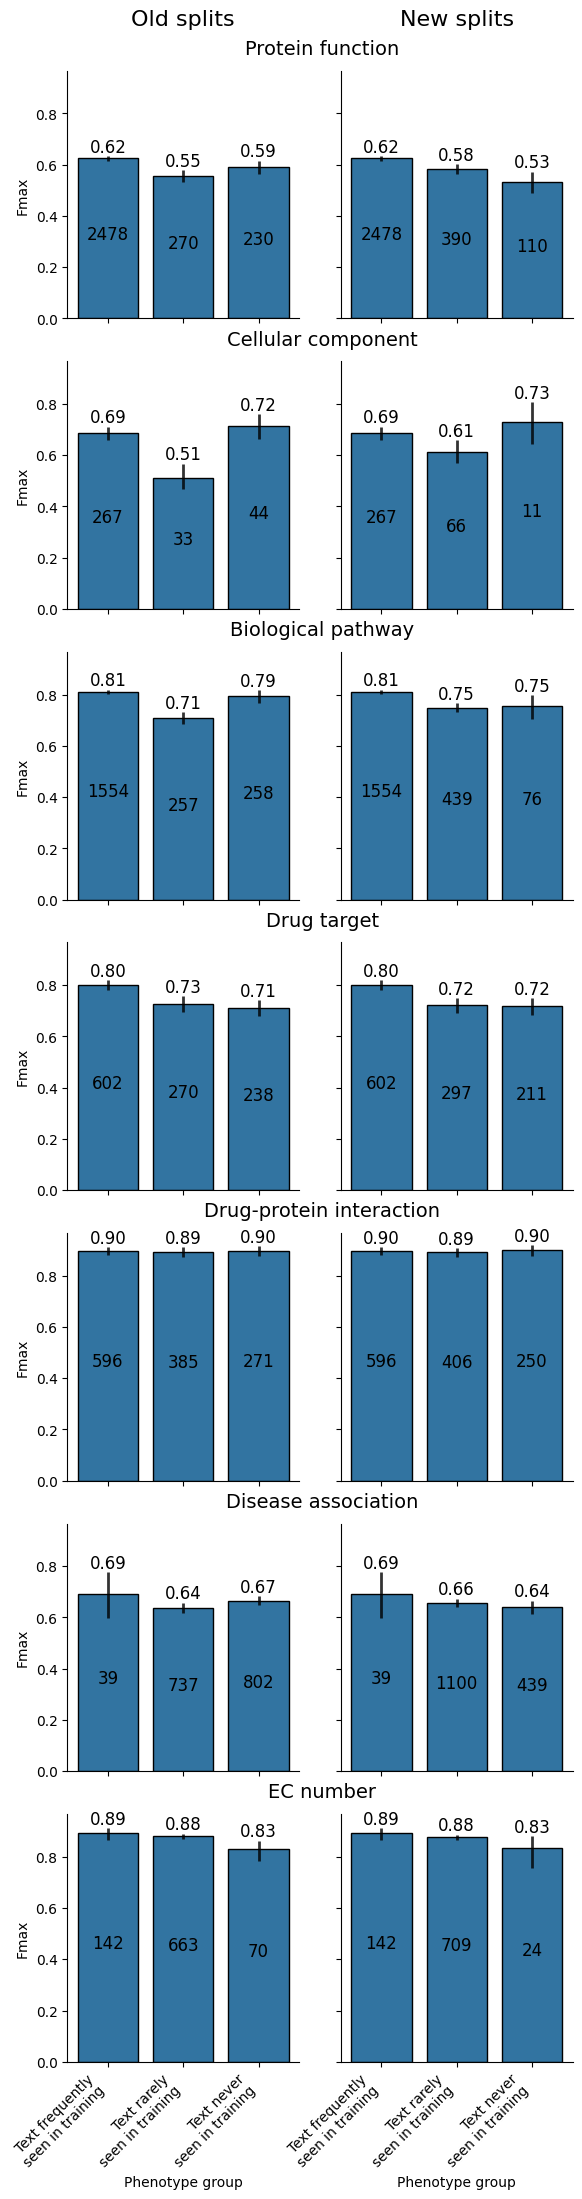

In [13]:
split_comparison_plot(plot_data, "Fmax")

## QA

In [14]:
procyon_data = all_qa_results.query("model == 'ProCyon'")
plot_data = (
    pd.concat((
        procyon_data[["correct", "plot_task", "plot_split"]].assign(split_groups="new"),
        (procyon_data[["correct", "plot_task", "orig_plot_split"]]
        .rename(columns={"orig_plot_split": "plot_split"})
        .assign(split_groups="old")),
    ))
    .assign(
        plot_split=lambda x: x.plot_split.map(split_rename),
        split_groups=lambda x: x.split_groups.str.title(),
    )
)
plot_data.head()

,correct,plot_task,plot_split,split_groups
0,True,Protein function,Text frequently\nseen in training,New
1,False,Protein function,Text frequently\nseen in training,New
2,False,Protein function,Text frequently\nseen in training,New
3,False,Protein function,Text frequently\nseen in training,New
4,True,Protein function,Text frequently\nseen in training,New


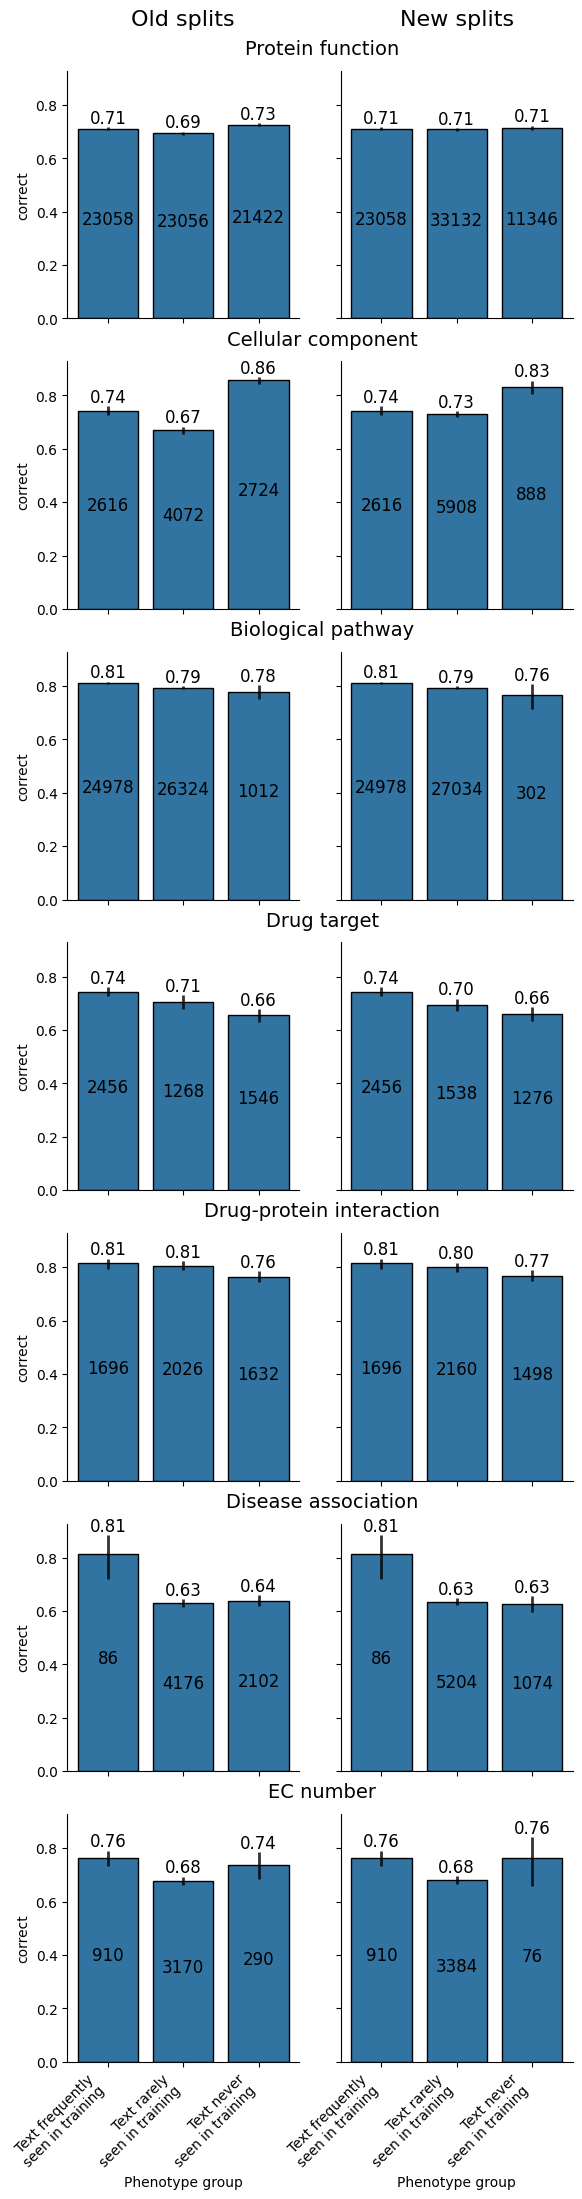

In [15]:
split_comparison_plot(plot_data, "correct")

# Benchmarking plots

In [22]:
retrieval_benchmark_results = all_results.copy()
retrieval_benchmark_results.loc[lambda x: (x.model == our_model_name) & (x.plot_split == "zero_shot"), "model"] = zero_shot_name

qa_benchmark_results = all_qa_results.copy()
qa_benchmark_results.loc[lambda x: (x.model == our_model_name) & (x.plot_split == "zero_shot"), "model"] = zero_shot_name

_split_maps_benchmarking = {
    "pt_ft": ["pt_ft"],
    "few_shot": ["few_shot"],
    "zero_shot": ["zero_shot_hard"],
}
split_maps_benchmarking = {
    x : k for k, v in _split_maps_benchmarking.items() for x in v
}

def map_split_benchmarking(x):
    return split_maps_benchmarking.get(x, "few_shot")

In [29]:
def annotated_bar_plot_horizontal(
    plot_data: pd.DataFrame,
    model_order: List[str],
    metric: str,
    static_colors: bool=True,
    textsize: float = 12,
    height: float = 5,
    fontscale: float = 2,
    col_wrap: int = 4,
):
    sns.set_theme(context="paper", style="ticks", font_scale=fontscale)
    sns.set_style("ticks")
    fg = sns.FacetGrid(
        data=plot_data,
        col="plot_task",
        col_wrap=col_wrap,
        height=height,
        aspect=1,
        margin_titles=True,
    )
    if static_colors:
        palette = {model: model_colors[model] for model in model_order}
    else:
        oth_models = [x for x in model_order if our_model_name not in x]
        palette = {x: color for x, color in zip(oth_models,sns.color_palette())}
        palette[our_model_name] = procyon_color
        palette[zero_shot_name] = procyon_color

    fg.map_dataframe(
        sns.barplot,
        x=metric,
        y="model",
        order=model_order,
        edgecolor="black",
        hue="model",
        palette=palette,
        data=plot_data,
        errorbar=None,
    )

    fg.set_titles(template="{col_name}")
    fg.set_ylabels("")
    if metric == "Fmax":
        xlabel = "Retrieval $F_{\max}$"
    elif metric == "correct":
        xlabel = "QA Accuracy"
    else:
        xlabel = metric
    fg.set_xlabels(xlabel)

    plot_vals = []
    for task, ax in fg.axes_dict.items():
        rects = [x[0] for x in ax.containers]
        rects = sorted(rects, key=lambda x: x.get_y())

        x_coords = []
        y_coords = []
        yerr = []

        procyon_x_coords = []
        procyon_y_coords = []
        procyon_yerr = []
        for rect, model in zip(rects, model_order):
            want_df = plot_data.query("plot_task == @task and model == @model")
            err_lb, err_ub = calc_error_bounds(want_df[metric].values)

            yval = rect.get_center()[1]
            xval = rect.get_width()

            if our_model_name not in model:
                rect.set(alpha=0.3)
                x_coords.append(xval)
                y_coords.append(yval)
                yerr.append(np.abs((err_lb - xval, err_ub - xval)))
            else:
                procyon_x_coords.append(xval)
                procyon_y_coords.append(yval)
                procyon_yerr.append(np.abs((err_lb - xval, err_ub - xval)))

            if model == zero_shot_name:
                rect.set(hatch="xx")

            # Add text above the bar
            ax.text(
                x=err_ub + 0.01,
                y=yval,
                s=f"{xval:.2f}",
                ha="left",
                va="center",
                fontsize=textsize,
            )

            plot_vals.append({
                "task": task,
                "model": model,
                "mean": xval,
                "err_lb": err_lb,
                "err_ub": err_ub,
            })

        yerr = np.array(yerr).T
        ax.errorbar(
            x=x_coords,
            y=y_coords,
            xerr=yerr,
            fmt="none",
            c="k",
            alpha=0.5,
            elinewidth=2,
        )

        procyon_yerr = np.array(procyon_yerr).T
        ax.errorbar(
            x=procyon_x_coords,
            y=procyon_y_coords,
            xerr=procyon_yerr,
            fmt="none",
            c="k",
            alpha=0.9,
            elinewidth=2,
        )
    return pd.DataFrame(plot_vals)

## Retrieval

In [33]:
# We need different split maps here since most of the baselines
# can't handle the zero-shot phenotypes that we're treating as few-shot now.
retrieval_data = (
    retrieval_benchmark_results
    .loc[lambda x: ~x.orig_split.isin(["zero_shot_easy", "zero_shot"])]
    .loc[lambda x: (x.plot_split != "zero_shot") | (x.model == zero_shot_name)]
)
retrieval_data.model.value_counts()


model
ProCyon                6658
BioTranslator          6658
ProtST                 6658
MajorityRule           6658
WeightedRandom         6658
UniformRandom          6658
ESM3MLP                6322
ESM3Knn                6322
BlastKnn               6322
ESMKnn                 6322
GearNetMLP             6322
GearNetKnn             6322
ESMMLP                 6322
ProCyon (zero shot)    1121
Name: count, dtype: int64

In [39]:
main_fig_models = {
    "BlastKnn": "BLAST-kNN",
    "ESM3MLP": "ESM3-MLP",
    "GearNetMLP": "GearNet-MLP",
    "BioTranslator": "BioTranslator",
    "ProtST": "ProtST",
    "ProCyon": "ProCyon",
}

model_order = list(main_fig_models.values())

In [40]:
plot_data = (
    retrieval_data
    .loc[lambda x: x.model.isin(main_fig_models)]
    .loc[lambda x: x.plot_task != "EC number"]
    .assign(model=lambda x: x.model.map(main_fig_models))
    .reset_index(drop=True)
)
plot_data.head()

,query_id,precision_k10,recall_k10,precision_k20,recall_k20,precision_k100,recall_k100,Fmax,auroc,auprc,dataset_relation,dataset,orig_split,orig_plot_split,plot_split,plot_task,model
0,0,0.30,0.750000,0.170000,0.85,0.090909,1.0,0.732857,0.881875,0.652682,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
1,1,0.20,1.000000,0.100000,1.00,0.090909,1.0,1.000000,1.000000,1.000000,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
2,5,0.20,1.000000,0.100000,1.00,0.090909,1.0,0.603175,0.887500,0.512143,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
3,8,0.22,0.733333,0.150000,1.00,0.090909,1.0,0.667619,0.881111,0.577133,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
4,9,0.10,1.000000,0.090909,1.00,0.090909,1.0,0.866667,0.970000,0.800000,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon


In [41]:
#TODO: why do ProCyon, BioTranslator, and ProtST have more here?
plot_data.model.value_counts()

model
ProCyon          6487
BioTranslator    6487
ProtST           6487
BLAST-kNN        6151
ESM3-MLP         6151
GearNet-MLP      6151
Name: count, dtype: int64

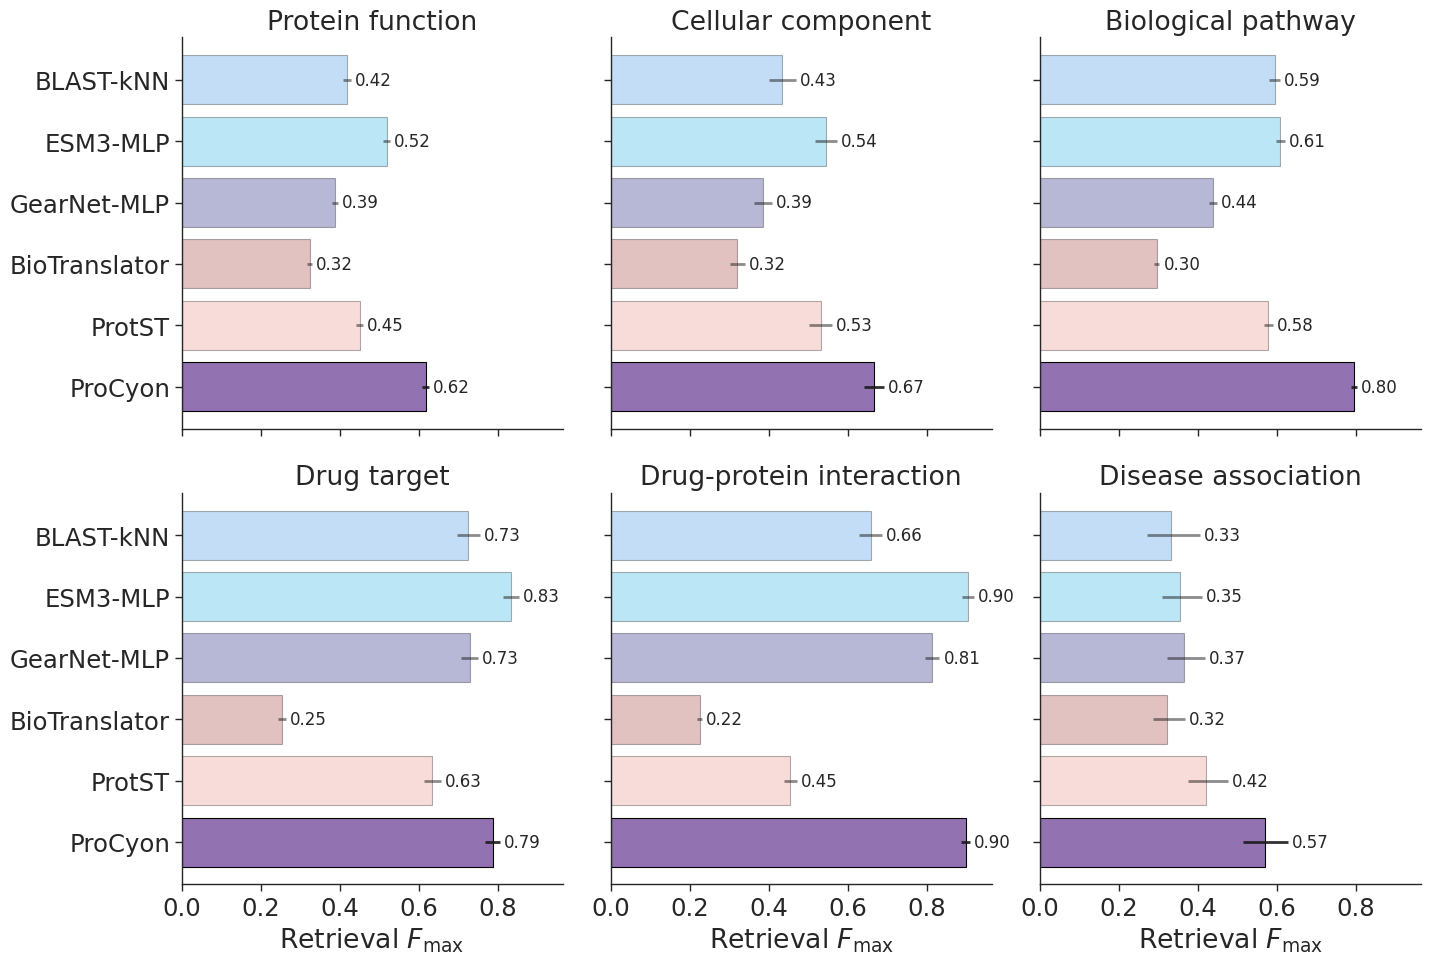

In [42]:
ret_df = annotated_bar_plot_horizontal(
    plot_data,
    model_order=model_order,
    metric="Fmax",
    textsize=12,
    col_wrap=3,
)

## QA

In [32]:
main_fig_models = {
    "BlastKnn": "BLAST-kNN",
    "ESM3MLP": "ESM3-MLP",
    "GearNetMLP": "GearNet-MLP",
    # TODO: add back in once we've regenerated results
    #"ProtLLM" : "ProtLLM"
    "ProCyon": "ProCyon",
}

model_order = list(main_fig_models.values())

In [33]:
# We need different split maps here since most of the baselines
# can't handle the zero-shot phenotypes that we're treating as few-shot now.
qa_data = (
    qa_benchmark_results
    .loc[lambda x: ~x.orig_split.isin(["zero_shot_easy", "zero_shot"])]
    .loc[lambda x: (x.plot_split != "zero_shot") | (x.model == zero_shot_name)]
)
qa_data.model.value_counts()


model
ProCyon                115636
BlastKnn               114546
ESM3Knn                114546
ESM3MLP                114546
ESMKnn                 114546
ESMMLP                 114546
GearNetKnn             114546
GearNetMLP             114546
ProCyon (zero shot)     16460
Name: count, dtype: int64

In [34]:
plot_data = (
    qa_data
    .loc[lambda x: x.model.isin(main_fig_models)]
    .loc[lambda x: x.plot_task != "EC number"]
    .assign(model=lambda x: x.model.map(main_fig_models))
    .reset_index(drop=True)
)
plot_data.head()

,correct,dataset_relation,dataset,orig_split,orig_plot_split,plot_split,plot_task,model
0,True,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
1,False,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
2,False,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
3,False,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
4,True,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon


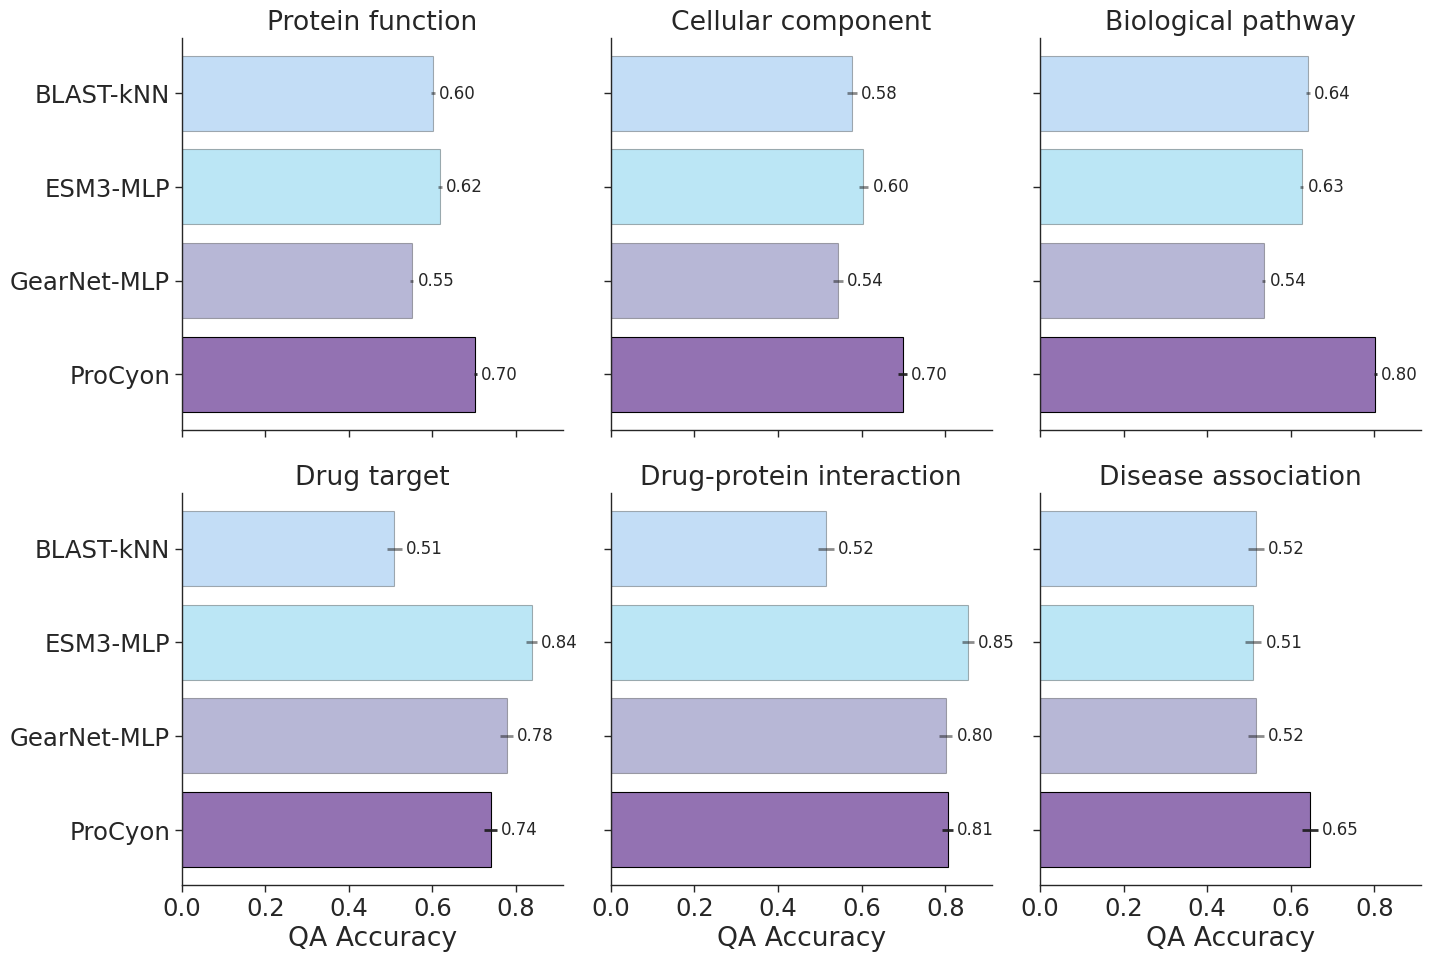

In [35]:
annotated_bar_plot_horizontal(
    plot_data,
    model_order=model_order,
    metric="correct",
    col_wrap=3,
)

# Extended data

## Full baseline set - retrieval

In [34]:
extended_models = {
    "UniformRandom": "Random",
    "BlastKnn": "BLAST-kNN",
    "ESMKnn": "ESM2-kNN",
    "ESMMLP": "ESM2-MLP",
    "ESM3Knn": "ESM3-kNN",
    "ESM3MLP": "ESM3-MLP",
    "GearNetKnn": "GearNet-kNN",
    "GearNetMLP": "GearNet-MLP",
    "BioTranslator": "BioTranslator",
    "ProtST": "ProtST",
    "ProCyon": "ProCyon",
}

extended_model_order = list(extended_models.values())

In [35]:
plot_data = (
    retrieval_data
    .loc[lambda x: x.model.isin(extended_models)]
    .assign(model=lambda x: x.model.map(extended_models))
    .reset_index(drop=True)
)
plot_data.head()

,query_id,precision_k10,recall_k10,precision_k20,recall_k20,precision_k100,recall_k100,Fmax,auroc,auprc,dataset_relation,dataset,orig_split,orig_plot_split,plot_split,plot_task,model
0,0,0.30,0.750000,0.170000,0.85,0.090909,1.0,0.732857,0.881875,0.652682,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
1,1,0.20,1.000000,0.100000,1.00,0.090909,1.0,1.000000,1.000000,1.000000,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
2,5,0.20,1.000000,0.100000,1.00,0.090909,1.0,0.603175,0.887500,0.512143,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
3,8,0.22,0.733333,0.150000,1.00,0.090909,1.0,0.667619,0.881111,0.577133,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
4,9,0.10,1.000000,0.090909,1.00,0.090909,1.0,0.866667,0.970000,0.800000,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon


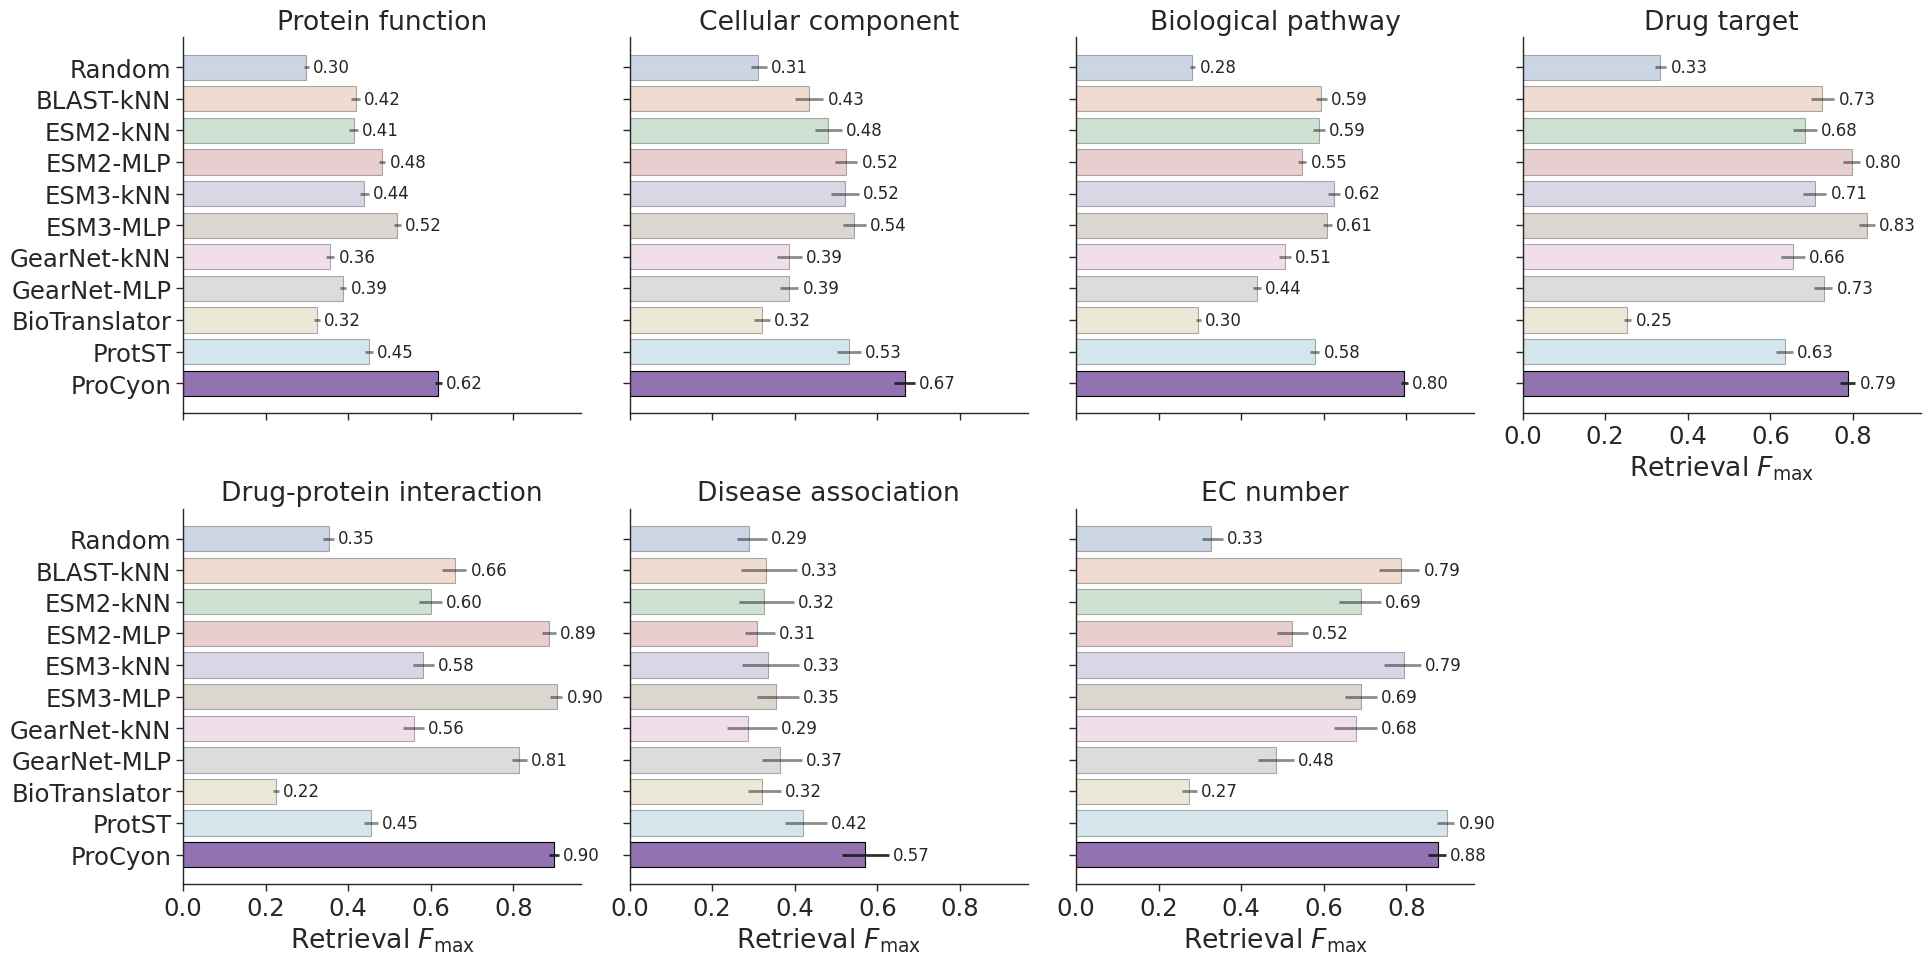

In [38]:
ret_df = annotated_bar_plot_horizontal(
    plot_data,
    model_order=extended_model_order,
    metric="Fmax",
    static_colors=False,
)
plt.savefig(os.path.expanduser("~/tmp/test.pdf"))

In [50]:
ret_df

,task,model,mean,err_lb,err_ub
0,Protein function,Random,0.298118,0.292436,0.304296
1,Protein function,BLAST-kNN,0.417687,0.407379,0.428784
2,Protein function,ESM2-kNN,0.413126,0.402884,0.423947
3,Protein function,ESM2-MLP,0.481651,0.473469,0.490148
4,Protein function,ESM3-kNN,0.438800,0.428005,0.449863
...,...,...,...,...,...
72,EC number,GearNet-kNN,0.678107,0.625500,0.727999
73,EC number,GearNet-MLP,0.483258,0.440537,0.527610
74,EC number,BioTranslator,0.272928,0.257112,0.292312
75,EC number,ProtST,0.897569,0.874315,0.916270


In [48]:
ret_df.to_csv("~/tmp/retrieval_results.csv", index=False)

In [23]:
plot_data.groupby("model").Fmax.describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
BLAST-kNN,6322.0,0.529994,0.333674,0.166667,0.166667,0.499277,0.893939,1.0
BioTranslator,6658.0,0.294812,0.151376,0.166667,0.190165,0.237230,0.337143,1.0
ESM-MLP,6322.0,0.569773,0.267068,0.166667,0.340952,0.523353,0.800000,1.0
ESM-kNN,6322.0,0.516550,0.321063,0.166667,0.166667,0.492233,0.818139,1.0
ESM3-MLP,6322.0,0.614966,0.266557,0.166667,0.380937,0.600000,0.866667,1.0
ESM3-kNN,6322.0,0.543494,0.322035,0.166667,0.166667,0.539925,0.865606,1.0
GearNet-MLP,6322.0,0.477224,0.261511,0.166667,0.257967,0.393333,0.647619,1.0
GearNet-kNN,6322.0,0.456065,0.311637,0.166667,0.166667,0.350476,0.700952,1.0
ProCyon,6658.0,0.727713,0.241411,0.166667,0.537998,0.767212,0.960000,1.0


In [27]:
plot_data.head()

,query_id,precision_k10,recall_k10,precision_k20,recall_k20,precision_k100,recall_k100,Fmax,auroc,auprc,dataset_relation,dataset,orig_split,orig_plot_split,plot_split,plot_task,model
0,0,0.30,0.750000,0.170000,0.85,0.090909,1.0,0.732857,0.881875,0.652682,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
1,1,0.20,1.000000,0.100000,1.00,0.090909,1.0,1.000000,1.000000,1.000000,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
2,5,0.20,1.000000,0.100000,1.00,0.090909,1.0,0.603175,0.887500,0.512143,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
3,8,0.22,0.733333,0.150000,1.00,0.090909,1.0,0.667619,0.881111,0.577133,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
4,9,0.10,1.000000,0.090909,1.00,0.090909,1.0,0.866667,0.970000,0.800000,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon


In [28]:
plot_data.query("model == 'ProCyon' and dataset == 'protein_drugbank'").dataset_relation.value_counts()

dataset_relation
protein_drugbank:drug_target         696
protein_drugbank:drug_enzyme         459
protein_drugbank:drug_transporter    273
protein_drugbank:drug_carrier        113
Name: count, dtype: int64

In [32]:
plot_data.query("model == 'ProCyon' and dataset == 'protein_drugbank'").orig_split.value_counts()

orig_split
pt_ft       1198
few_shot     343
Name: count, dtype: int64

In [33]:
plot_data.query("model == 'ESM3-MLP' and dataset == 'protein_drugbank'").orig_split.value_counts()

orig_split
pt_ft       1008
few_shot     197
Name: count, dtype: int64

## Full baseline set - QA

In [40]:
extended_models = {
    "BlastKnn": "BLAST-kNN",
    "ESMKnn": "ESM-kNN",
    "ESMMLP": "ESM-MLP",
    "ESM3Knn": "ESM3-kNN",
    "ESM3MLP": "ESM3-MLP",
    "GearNetKnn": "GearNet-kNN",
    "GearNetMLP": "GearNet-MLP",
    "ProtLLM" : "ProtLLM",
    "ProCyon": "ProCyon",
}

extended_model_order = list(extended_models.values())

In [41]:
# We need different split maps here since most of the baselines
# can't handle the zero-shot phenotypes that we're treating as few-shot now.
qa_data = (
    qa_benchmark_results
    .loc[lambda x: ~x.orig_split.isin(["zero_shot_easy", "zero_shot"])]
    .loc[lambda x: (x.plot_split != "zero_shot") | (x.model == zero_shot_name)]
)
qa_data.model.value_counts()


model
ProCyon                115636
ProtLLM                115636
BlastKnn               114546
ESM3Knn                114546
ESMKnn                 114546
ESM3MLP                114546
ESMMLP                 114546
GearNetKnn             114546
GearNetMLP             114546
ProCyon (zero shot)     16460
Name: count, dtype: int64

In [42]:
plot_data = (
    qa_data
    .loc[lambda x: x.model.isin(extended_models)]
    .assign(model=lambda x: x.model.map(extended_models))
    .reset_index(drop=True)
)
plot_data.head()

,correct,dataset_relation,dataset,orig_split,orig_plot_split,plot_split,plot_task,model
0,True,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
1,False,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
2,False,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
3,False,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon
4,True,protein_go:process,protein_go,pt_ft,pt_ft,pt_ft,Protein function,ProCyon


In [43]:
plot_data.groupby("model").correct.mean().sort_values()

model
ProtLLM        0.509712
GearNet-MLP    0.556152
ESM-MLP        0.589519
GearNet-kNN    0.593727
BLAST-kNN      0.617289
ESM-kNN        0.621567
ESM3-MLP       0.630376
ESM3-kNN       0.634653
ProCyon        0.748608
Name: correct, dtype: float64

In [44]:
import matplotlib.pyplot as plt

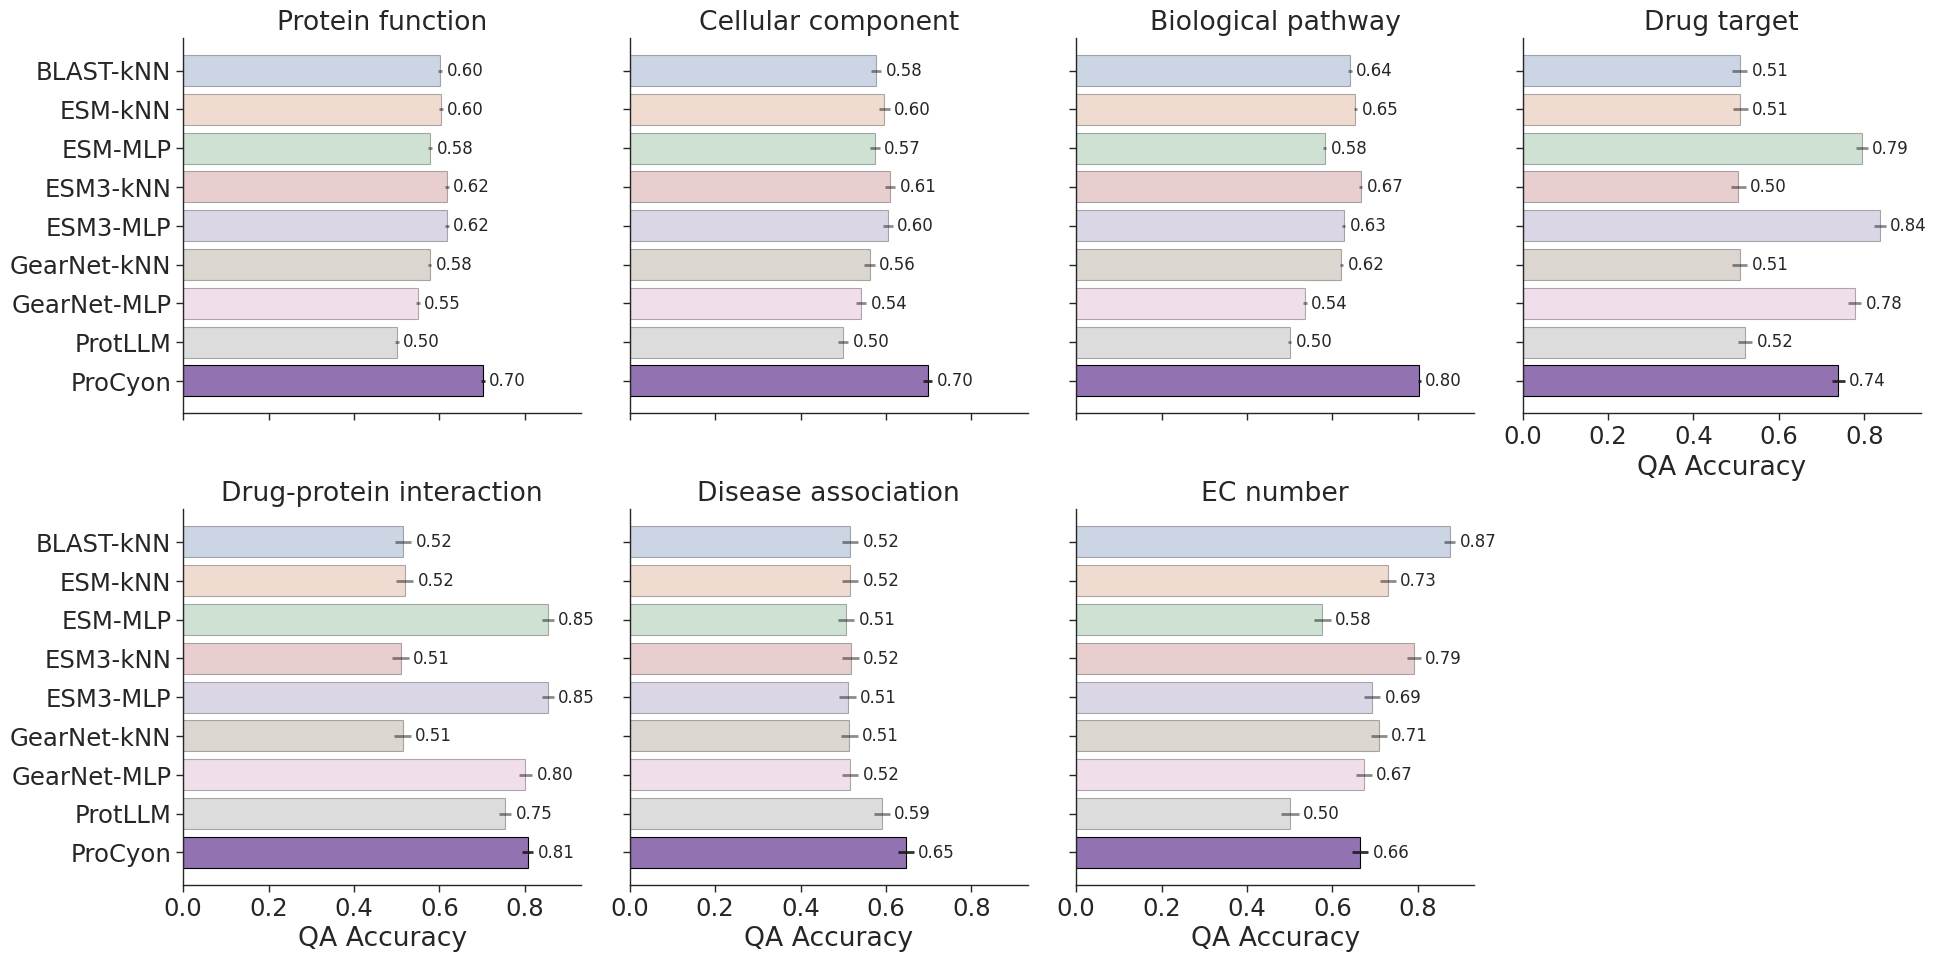

In [45]:
ret_df = annotated_bar_plot_horizontal(
    plot_data,
    model_order=extended_model_order,
    metric="correct",
    static_colors=False,
)
plt.savefig(os.path.expanduser("~/tmp/qa_w_protllm.pdf"))

In [32]:
ret_df.head()

,task,model,mean,err_lb,err_ub
0,Protein function,BLAST-kNN,0.601704,0.597151,0.606131
1,Protein function,ESM-kNN,0.602810,0.598322,0.607321
2,Protein function,ESM-MLP,0.578393,0.574056,0.582903
3,Protein function,ESM3-kNN,0.617470,0.613046,0.621807
4,Protein function,ESM3-MLP,0.617166,0.612807,0.621596


In [33]:
ret_df.to_csv("~/tmp/qa_results.csv", index=False)

## Performance across splits - retrieval

In [75]:
def across_split_perf_plot(
    data: pd.DataFrame,
    metric: str,
    model_order: List[str],
    col_order: List[str] = split_order,
):
    fg = sns.FacetGrid(
        data=data,
        row="plot_task",
        col="plot_split",
        margin_titles=False,
        col_order=col_order,
    )

    fg.map_dataframe(
        sns.barplot,
        x="model",
        hue="model",
        palette=model_colors,
        y=metric,
        order=model_order,
        edgecolor="black",
        errorbar=None,
    )
    # Set column titles only for the first row
    for col_idx, col_name in enumerate(fg.col_names):
        fg.axes[0, col_idx].set_title(f"{col_name} splits", fontsize=16, y=1.15, fontweight="normal")

    # Remove column titles for all other rows
    for i in range(1, len(fg.row_names)):
        for j in range(len(fg.col_names)):
            fg.axes[i, j].set_title("")

    fg.set_xlabels("")
    if metric == "Fmax":
        ylabel = "Retrieval $F_{\max}$"
    elif metric == "correct":
        ylabel = "QA Accuracy"
    else:
        ylabel = metric
    fg.set_ylabels(ylabel)

    # Add subtitles for each row
    for i, row_val in enumerate(fg.row_names):
        # Get middle axis for this row
        ax = fg.axes[i, 1]
        ax.annotate(
            row_val,
            xy=(0.5, 1.05),
            xycoords="axes fraction",
            ha="center",
            va="bottom",
            fontsize=14,
            fontweight="normal"
        )

    bottom_row_idx = len(fg.row_names) - 1
    for ax in fg.axes[bottom_row_idx, :]:
        for label in ax.get_xticklabels():
            label.set(rotation=45, rotation_mode="anchor", ha="right")

    ret_df = []
    for (task, split), ax in fg.axes_dict.items():
        rects = [x[0] for x in ax.containers]
        rects = sorted(rects, key=lambda x: x.get_x())

        x_coords = []
        y_coords = []
        yerr = []
        for rect, model in zip(rects, model_order):
            want_df = plot_data.query("plot_split == @split and plot_task == @task and model == @model")
            err_lb, err_ub = calc_error_bounds(want_df[metric].values)

            xval = rect.get_center()[0]
            yval = rect.get_height()

            x_coords.append(xval)
            y_coords.append(yval)
            yerr.append(np.abs((err_lb - yval, err_ub - yval)))

            # Add text above the bar
            ax.text(
                x=xval,
                y=err_ub,
                s=f"{yval:.2f}",
                ha="center",
                va="bottom",
                fontsize=12,
            )
            if our_model_name not in model:
                rect.set(alpha=0.3)
            ret_df.append({
                "task": task,
                "split": split,
                "model": model,
                "mean": yval,
                "err_lb": err_lb,
                "err_ub": err_ub,
            })

        yerr = np.array(yerr).T
        ax.errorbar(
            x=x_coords,
            y=y_coords,
            yerr=yerr,
            fmt="none",
            c="k",
            alpha=0.8,
            elinewidth=2,
        )
    return pd.DataFrame(ret_df)


In [76]:
zero_shot_models = [
    "BioTranslator",
    "ProtST",
    our_model_name,
]
split_rename = {
    "pt_ft": "Many-shot",
    "few_shot": "Few-shot",
    "zero_shot": "Zero-shot",
}
plot_data = (
    all_results
    .loc[lambda x: x.model.isin(zero_shot_models)]
    .drop(columns=["orig_split", "orig_plot_split"])
    .assign(
        plot_split=lambda x: x.plot_split.map(split_rename),
    )
)
plot_data.head()

,query_id,precision_k10,recall_k10,precision_k20,recall_k20,precision_k100,recall_k100,Fmax,auroc,auprc,dataset_relation,dataset,plot_split,plot_task,model
0,0,0.30,0.750000,0.170000,0.85,0.090909,1.0,0.732857,0.881875,0.652682,protein_go:process,protein_go,Many-shot,Protein function,ProCyon
1,1,0.20,1.000000,0.100000,1.00,0.090909,1.0,1.000000,1.000000,1.000000,protein_go:process,protein_go,Many-shot,Protein function,ProCyon
2,5,0.20,1.000000,0.100000,1.00,0.090909,1.0,0.603175,0.887500,0.512143,protein_go:process,protein_go,Many-shot,Protein function,ProCyon
3,8,0.22,0.733333,0.150000,1.00,0.090909,1.0,0.667619,0.881111,0.577133,protein_go:process,protein_go,Many-shot,Protein function,ProCyon
4,9,0.10,1.000000,0.090909,1.00,0.090909,1.0,0.866667,0.970000,0.800000,protein_go:process,protein_go,Many-shot,Protein function,ProCyon


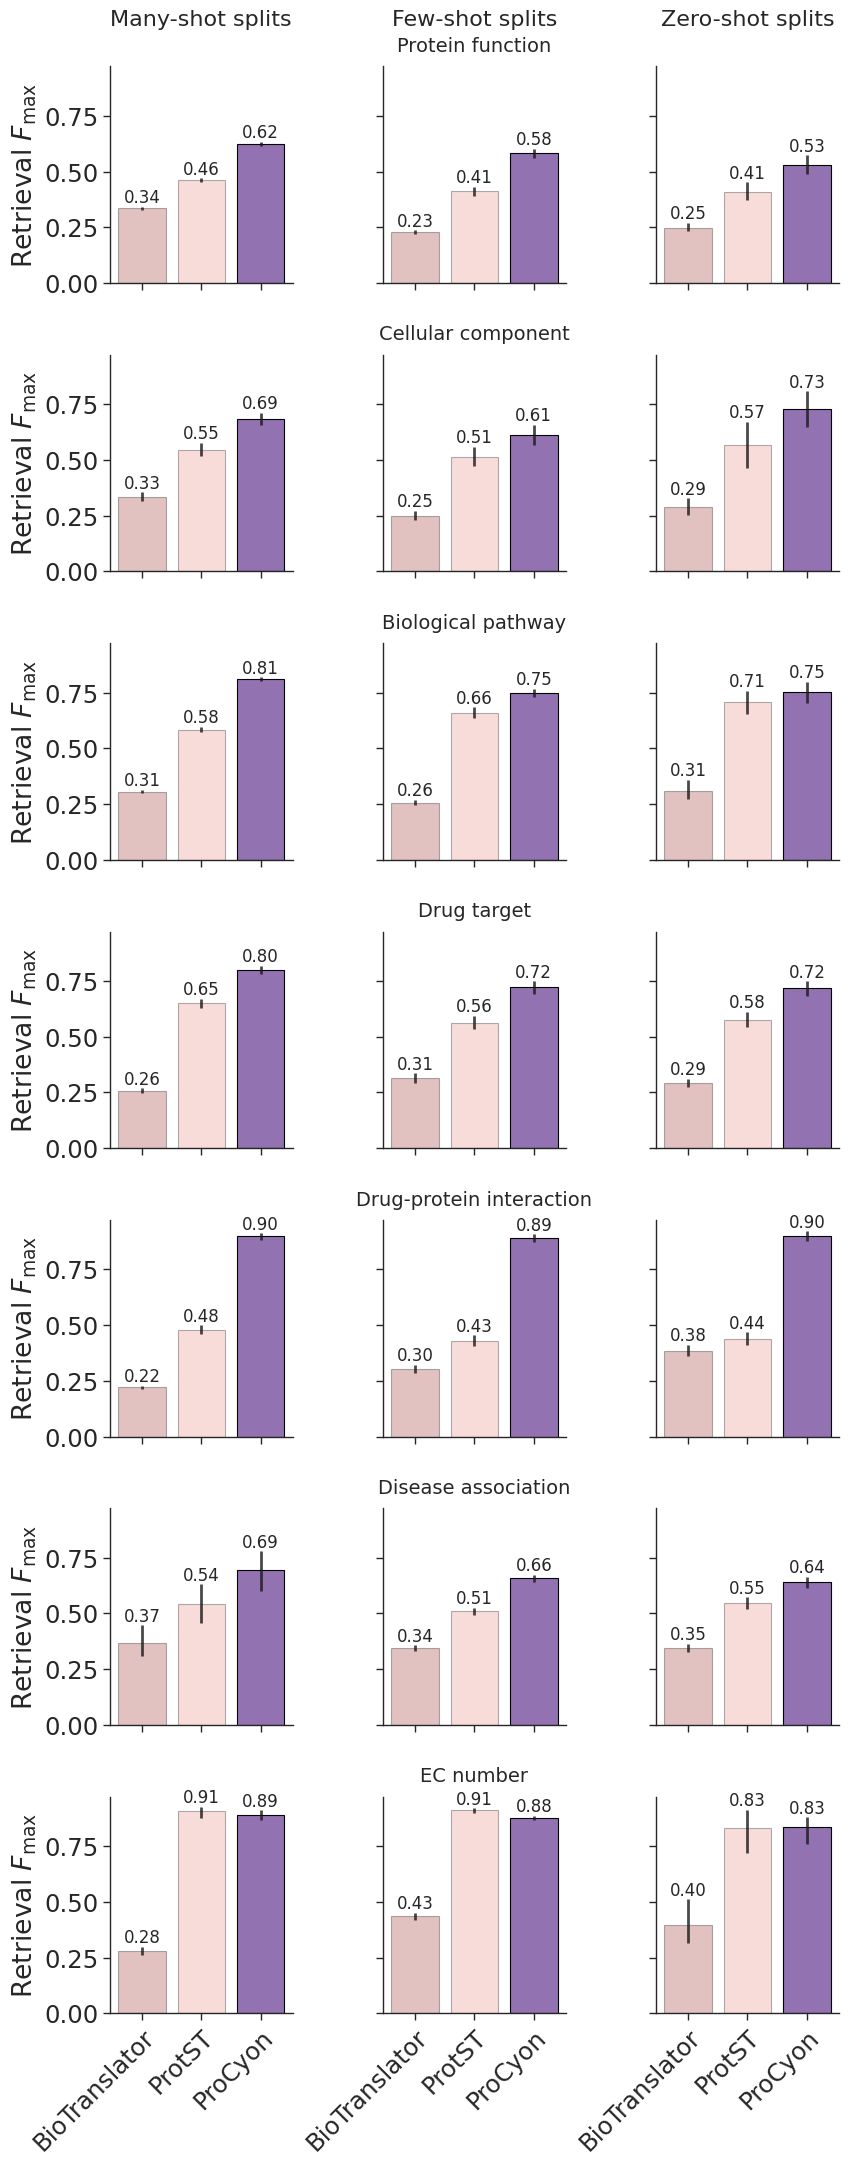

In [79]:
ret_df = across_split_perf_plot(
    plot_data,
    metric="Fmax",
    model_order=zero_shot_models,
    col_order=list(split_rename.values()),
)

In [80]:
ret_df.head()

,task,split,model,mean,err_lb,err_ub
0,Protein function,Many-shot,BioTranslator,0.335519,0.329075,0.342333
1,Protein function,Many-shot,ProtST,0.460845,0.451784,0.470703
2,Protein function,Many-shot,ProCyon,0.624665,0.615436,0.634490
3,Protein function,Few-shot,BioTranslator,0.228305,0.221541,0.236139
4,Protein function,Few-shot,ProtST,0.412092,0.392597,0.432873


In [81]:
ret_df.to_csv("~/tmp/retrieval_by_split.csv", index=False)

### ProCyon only

In [68]:
plot_data = (
    all_results
    .loc[lambda x: x.model == our_model_name]
    .loc[lambda x: x.plot_task != "EC number"]
    .drop(columns=["orig_split", "orig_plot_split"])
    .assign(
        plot_split=lambda x: x.plot_split.map(split_rename),
    )
)
plot_data.head()

,query_id,precision_k10,recall_k10,precision_k20,recall_k20,precision_k100,recall_k100,Fmax,auroc,auprc,dataset_relation,dataset,plot_split,plot_task,model
0,0,0.30,0.750000,0.170000,0.85,0.090909,1.0,0.732857,0.881875,0.652682,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon
1,1,0.20,1.000000,0.100000,1.00,0.090909,1.0,1.000000,1.000000,1.000000,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon
2,5,0.20,1.000000,0.100000,1.00,0.090909,1.0,0.603175,0.887500,0.512143,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon
3,8,0.22,0.733333,0.150000,1.00,0.090909,1.0,0.667619,0.881111,0.577133,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon
4,9,0.10,1.000000,0.090909,1.00,0.090909,1.0,0.866667,0.970000,0.800000,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon


In [69]:
split_palette = {
    split: to_rgba(procyon_color) for split in split_order
}
split_palette

{'Text frequently\nseen in training': (0.5803921568627451,
  0.403921568627451,
  0.7411764705882353,
  1.0),
 'Text rarely\nseen in training': (0.5803921568627451,
  0.403921568627451,
  0.7411764705882353,
  1.0),
 'Text never\nseen in training': (0.5803921568627451,
  0.403921568627451,
  0.7411764705882353,
  1.0)}

In [70]:
alphas = [0.3, 0.5, 1]
alpha_map = {
    split: alpha for split, alpha in zip(split_order, alphas)
}

In [71]:
task_order = [x for x in task_order if x != "EC number"]
task_order

['Protein function',
 'Cellular component',
 'Biological pathway',
 'Drug target',
 'Drug-protein interaction',
 'Disease association']

(0.0, 1.0)

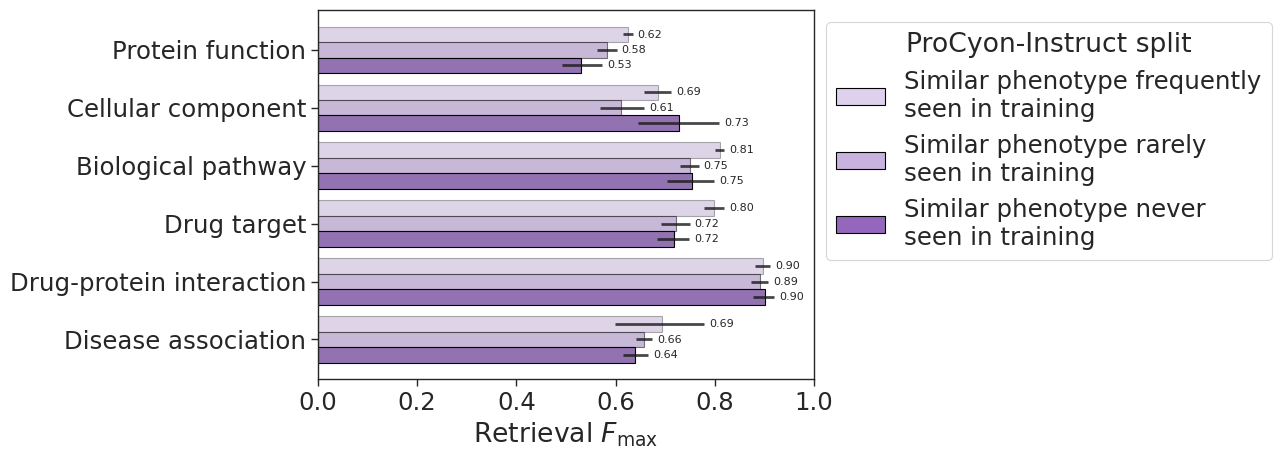

In [72]:
fontscale = 2
height = 6
metric = "Fmax"
textsize = 8

sns.set_theme(context="paper", style="ticks", font_scale=fontscale)
sns.set_style("ticks")
ax = sns.barplot(
    x=metric,
    y="plot_task",
    order=task_order,
    edgecolor="black",
    hue="plot_split",
    palette=split_palette,
    data=plot_data,
    errorbar=None,
)

if metric == "Fmax":
    xlabel = "Retrieval $F_{\max}$"
elif metric == "correct":
    xlabel = "QA Accuracy"
else:
    xlabel = metric
ax.set_xlabel(xlabel)
ax.set_ylabel("")

rects = [x for cont in ax.containers for x in cont]
rects = sorted(rects, key=lambda x: x.get_y())

x_coords = []
y_coords = []
yerr = []

procyon_x_coords = []
procyon_y_coords = []
procyon_yerr = []
for i, rect in enumerate(rects):
    task = task_order[i // len(split_order)]
    split = split_order[i % len(split_order)]
    want_df = plot_data.query("plot_task == @task and plot_split == @split")
    err_lb, err_ub = calc_error_bounds(want_df[metric].values)

    yval = rect.get_center()[1]
    xval = rect.get_width()

    alpha = alpha_map[split]
    rect.set(alpha=alpha)

    x_coords.append(xval)
    y_coords.append(yval)
    yerr.append(np.abs((err_lb - xval, err_ub - xval)))

    # Add text to right of the bar
    ax.text(
        x=err_ub + 0.01,
        y=yval,
        s=f"{xval:.2f}",
        ha="left",
        va="center",
        fontsize=textsize,
    )

yerr = np.array(yerr).T
ax.errorbar(
    x=x_coords,
    y=y_coords,
    xerr=yerr,
    fmt="none",
    c="k",
    alpha=0.8,
    elinewidth=2,
)

patches = []
for split, alpha in alpha_map.items():
    patch = mpatches.Patch(
        facecolor=to_rgba(procyon_color, alpha),
        label=split.replace("Text", "Similar phenotype"),
        edgecolor="black",
    )
    patches.append(patch)
ax.legend(title="ProCyon-Instruct split", handles=patches, loc="upper left", bbox_to_anchor=(1, 1))
ax.set_xlim(0, 1.0)


In [74]:
# Average performance by splits, across all datasets.
plot_data.groupby("plot_split").Fmax.mean()

plot_split
Text frequently\nseen in training    0.728418
Text never\nseen in training         0.711829
Text rarely\nseen in training        0.702460
Name: Fmax, dtype: float64

## Performance across splits - QA

In [82]:
zero_shot_models = [
    #"ProtLLM",
    our_model_name,
]

plot_data = (
    all_qa_results
    .loc[lambda x: x.model.isin(zero_shot_models)]
    .drop(columns=["orig_split", "orig_plot_split"])
    .assign(
        plot_split=lambda x: x.plot_split.map(split_rename),
    )
)
plot_data.head()

,correct,dataset_relation,dataset,plot_split,plot_task,model
0,True,protein_go:process,protein_go,Many-shot,Protein function,ProCyon
1,False,protein_go:process,protein_go,Many-shot,Protein function,ProCyon
2,False,protein_go:process,protein_go,Many-shot,Protein function,ProCyon
3,False,protein_go:process,protein_go,Many-shot,Protein function,ProCyon
4,True,protein_go:process,protein_go,Many-shot,Protein function,ProCyon


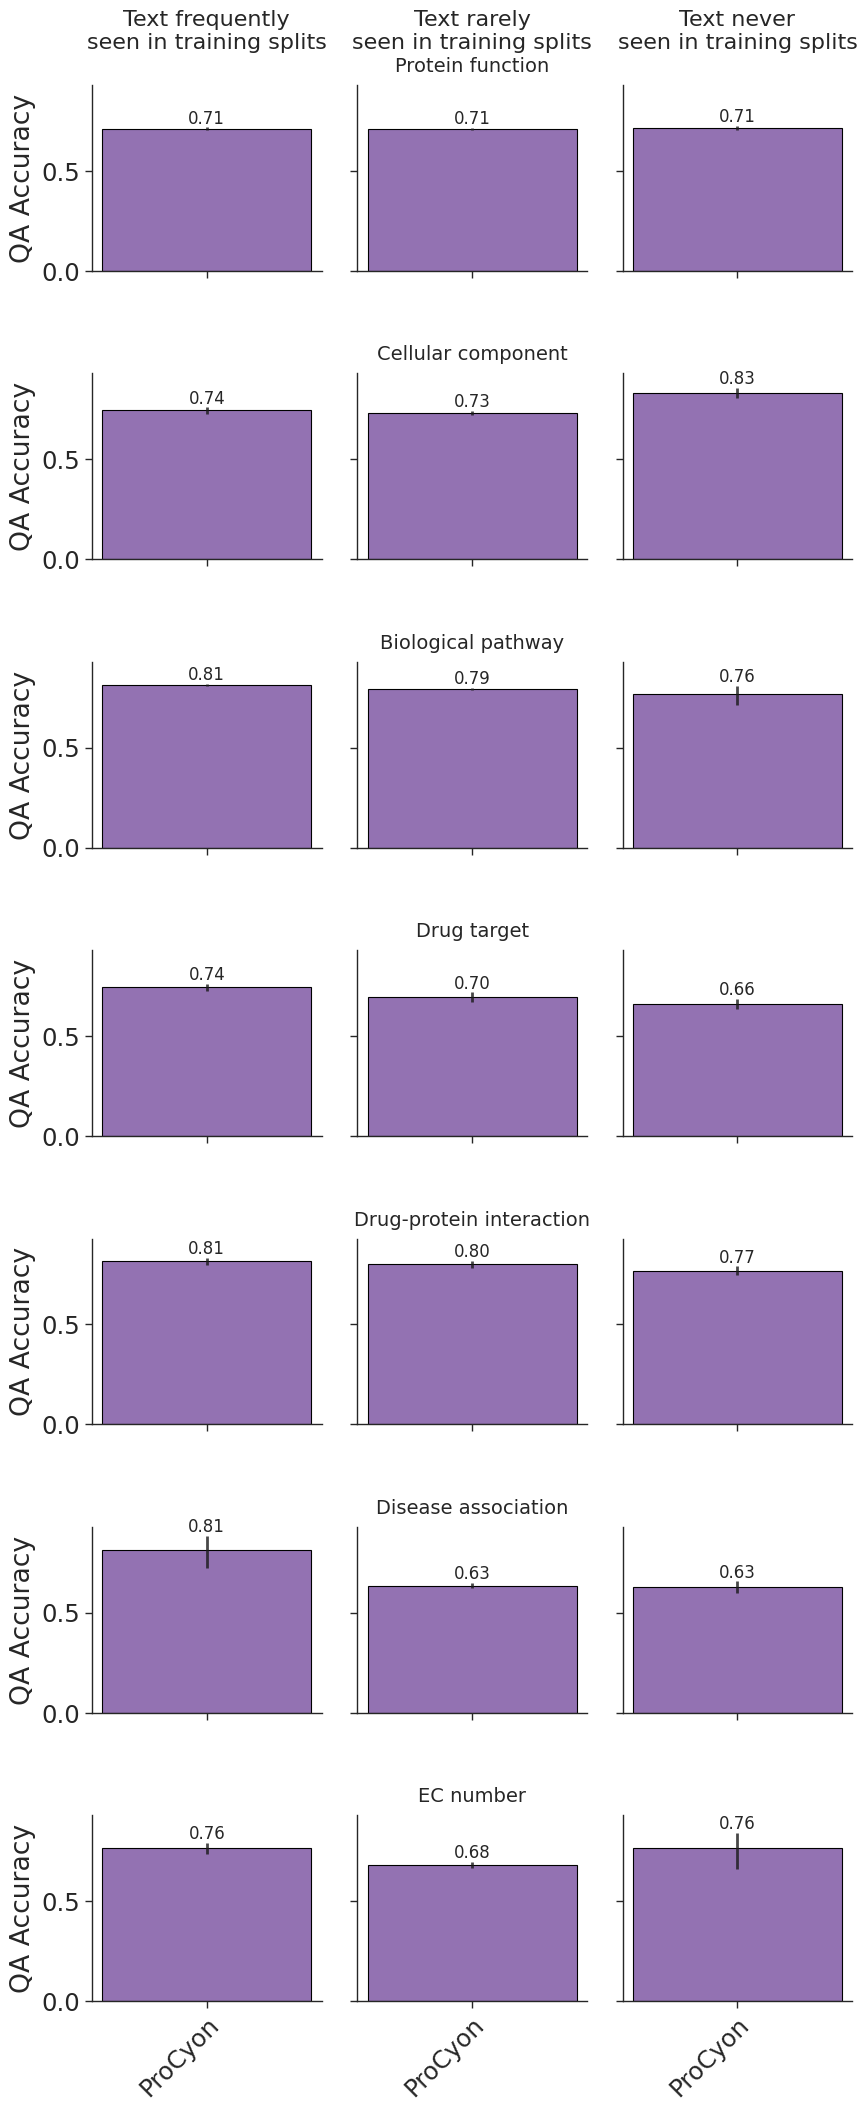

In [55]:
across_split_perf_plot(
    plot_data,
    metric="correct",
    model_order=zero_shot_models,
)

### ProCyon only

In [56]:
plot_data = (
    all_qa_results
    .loc[lambda x: x.model == our_model_name]
    .loc[lambda x: x.plot_task != "EC number"]
    .drop(columns=["orig_split", "orig_plot_split"])
    .assign(
        plot_split=lambda x: x.plot_split.map(split_rename),
    )
)
plot_data.head()

,correct,dataset_relation,dataset,plot_split,plot_task,model
0,True,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon
1,False,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon
2,False,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon
3,False,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon
4,True,protein_go:process,protein_go,Text frequently\nseen in training,Protein function,ProCyon


(0.0, 1.0)

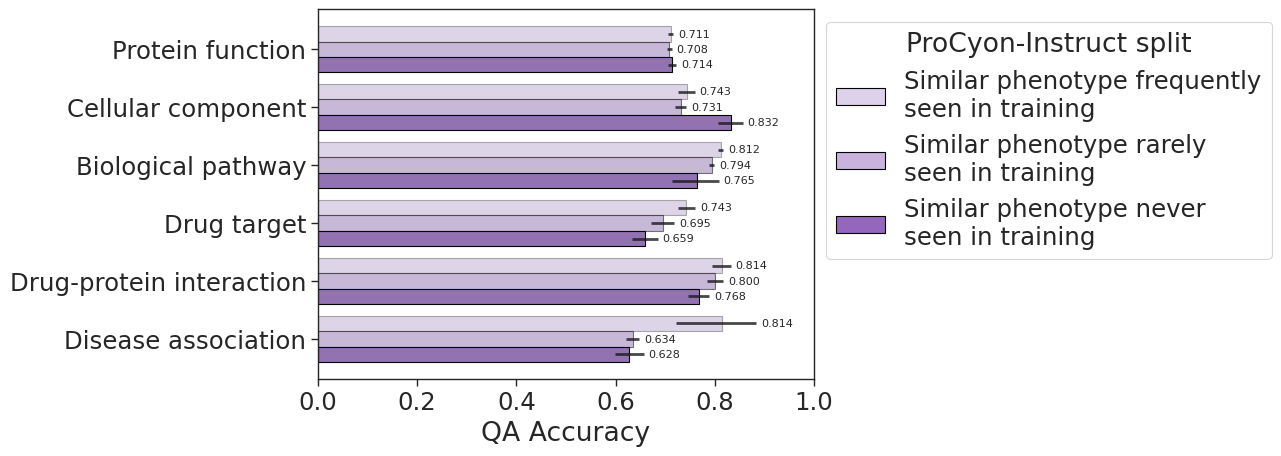

In [57]:
fontscale = 2
height = 6
metric = "correct"
textsize = 8

sns.set_theme(context="paper", style="ticks", font_scale=fontscale)
sns.set_style("ticks")
ax = sns.barplot(
    x=metric,
    y="plot_task",
    order=task_order,
    edgecolor="black",
    hue="plot_split",
    palette=split_palette,
    data=plot_data,
    errorbar=None,
)

if metric == "Fmax":
    xlabel = "Retrieval $F_{\max}$"
elif metric == "correct":
    xlabel = "QA Accuracy"
else:
    xlabel = metric
ax.set_xlabel(xlabel)
ax.set_ylabel("")

rects = [x for cont in ax.containers for x in cont]
rects = sorted(rects, key=lambda x: x.get_y())

x_coords = []
y_coords = []
yerr = []

procyon_x_coords = []
procyon_y_coords = []
procyon_yerr = []
for i, rect in enumerate(rects):
    task = task_order[i // len(split_order)]
    split = split_order[i % len(split_order)]
    want_df = plot_data.query("plot_task == @task and plot_split == @split")
    err_lb, err_ub = calc_error_bounds(want_df[metric].values)

    yval = rect.get_center()[1]
    xval = rect.get_width()

    alpha = alpha_map[split]
    rect.set(alpha=alpha)

    x_coords.append(xval)
    y_coords.append(yval)
    yerr.append(np.abs((err_lb - xval, err_ub - xval)))

    # Add text to right of the bar
    ax.text(
        x=err_ub + 0.01,
        y=yval,
        s=f"{xval:.3f}",
        ha="left",
        va="center",
        fontsize=textsize,
    )

yerr = np.array(yerr).T
ax.errorbar(
    x=x_coords,
    y=y_coords,
    xerr=yerr,
    fmt="none",
    c="k",
    alpha=0.8,
    elinewidth=2,
)

patches = []
for split, alpha in alpha_map.items():
    patch = mpatches.Patch(
        facecolor=to_rgba(procyon_color, alpha),
        label=split.replace("Text", "Similar phenotype"),
        edgecolor="black",
    )
    patches.append(patch)
ax.legend(title="ProCyon-Instruct split", handles=patches, loc="upper left", bbox_to_anchor=(1, 1))

ax.set_xlim(0, 1.0)
